In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing  
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier




In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<b> Data Wrangling<b>

- Age: replace missing values with the mean.
- Embarked: replace missing values with the most frequent value.
- Drop Cabin,Name,Ticket


In [4]:
train.replace(' ', np.nan, inplace = True)
test.replace(' ', np.nan, inplace = True)

In [5]:
train.drop(columns=["Cabin", "Name", "Ticket","PassengerId"], inplace=True)
test.drop(columns=["Cabin", "Name", "Ticket","PassengerId"], inplace=True)

In [6]:
mean_age = train['Age'].astype('float').mean(axis=0)
train["Age"] = train["Age"].replace(np.nan, mean_age)

mean_age = test['Age'].astype('float').mean(axis=0)
test["Age"] = test["Age"].replace(np.nan, mean_age)

In [7]:
if train["Embarked"].dropna().empty:
    Em = "U"  # Default value if column is empty
else:
    Em = train["Embarked"].value_counts().idxmax()

train["Embarked"] = train["Embarked"].fillna(Em)

if test["Embarked"].dropna().empty:
    Em = "U"  # Default value if column is empty
else:
    Em = test["Embarked"].value_counts().idxmax()

test["Embarked"] = test["Embarked"].fillna(Em)


In [8]:
def clean(data): 
    cols = ["SibSp", "Parch", "Fare"] 
    for col in cols:
        data[col] = data[col].fillna(data[col].median())  # Fill missing values with median
    return data

train = clean(train)
test  = clean(test)


In [9]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null

In [10]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


<b>Encoding<b>
- Convert categorical variables ("Sex" and "Embarked") in the train DataFrame into numerical values.

In [11]:
from sklearn import preprocessing  
le = preprocessing.LabelEncoder()
train["Sex"] = le.fit_transform(train["Sex"])
train["Embarked"] = le.fit_transform(train["Embarked"])
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [12]:
le = preprocessing.LabelEncoder()
test["Sex"] = le.fit_transform(test["Sex"])
test["Embarked"] = le.fit_transform(test["Embarked"])

In [13]:
print(train.corr()) #correlation matrix for the dataset

          Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived  1.000000 -0.338481 -0.543351 -0.069809 -0.035322  0.081629   
Pclass   -0.338481  1.000000  0.131900 -0.331339  0.083081  0.018443   
Sex      -0.543351  0.131900  1.000000  0.084153 -0.114631 -0.245489   
Age      -0.069809 -0.331339  0.084153  1.000000 -0.232625 -0.179191   
SibSp    -0.035322  0.083081 -0.114631 -0.232625  1.000000  0.414838   
Parch     0.081629  0.018443 -0.245489 -0.179191  0.414838  1.000000   
Fare      0.257307 -0.549500 -0.182333  0.091566  0.159651  0.216225   
Embarked -0.167675  0.162098  0.108262 -0.026749  0.068230  0.039798   

              Fare  Embarked  
Survived  0.257307 -0.167675  
Pclass   -0.549500  0.162098  
Sex      -0.182333  0.108262  
Age       0.091566 -0.026749  
SibSp     0.159651  0.068230  
Parch     0.216225  0.039798  
Fare      1.000000 -0.224719  
Embarked -0.224719  1.000000  


<b>Feature Engineering<b>

Create a new feature (FamilySize) by combining (SibSp) and (Parch) , plus 1 for the passenger themselves


In [14]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = 0  #new feature (IsAlone) as 0 (meaning not alone)
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1 #if the passenger has no family (FamilySize = 1) so the passenger alone 

test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

In [15]:
train.info()
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int64  
 8   FamilySize  891 non-null    int64  
 9   IsAlone     891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   SibSp       418 non-null    int64  
 4

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0,3,1,22.0,1,0,7.2500,2,2,0
1,1,1,0,38.0,1,0,71.2833,0,2,0
2,1,3,0,26.0,0,0,7.9250,2,1,1
3,1,1,0,35.0,1,0,53.1000,2,2,0
4,0,3,1,35.0,0,0,8.0500,2,1,1


<b> MODEL TRAINING  <b>

In [16]:
X = train[['Parch','Sex','Age','SibSp','Pclass','Fare','Embarked','IsAlone','FamilySize']]
Y = train['Survived']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

<b> Model 1:Logistic regression model<b>
- Predict the Survived value,  by using all the attribute of the dataset.

In [17]:
lm = LogisticRegression(max_iter=1000, random_state=0).fit(X_train, Y_train)
lm.fit(X_train, Y_train)
lm.score(X_train, Y_train)

0.8019662921348315

<b> Model 2: Random Forest <b>

In [18]:
rf = RandomForestClassifier(n_estimators=600, random_state=100)
rf.fit(X_train, Y_train)
rf.score(X_train, Y_train)

0.9803370786516854

<b>Model 3: SVC (Support Vector Classification)<b>

In [19]:
SVC = SVC(kernel='rbf', C=600, random_state=100)
SVC.fit(X_train, Y_train)
SVC.score(X_train, Y_train)

0.8314606741573034

<b> Model Evaluation Metrics & Confusion matrix <b>

for model 1:

In [20]:
predictions_1 = lm.predict(X_val)
ac = accuracy_score(Y_val,predictions_1)
pr = precision_score(Y_val, predictions_1)
re = recall_score(Y_val, predictions_1)
f1 = f1_score(Y_val, predictions_1)
print( "Model Evaluation Metrics:")
print("Accuracy:",ac)
print("Precision:",pr)
print("Recall:",re)
print("F1 Score:",f1)

Model Evaluation Metrics:
Accuracy: 0.7988826815642458
Precision: 0.7714285714285715
Recall: 0.7297297297297297
F1 Score: 0.75


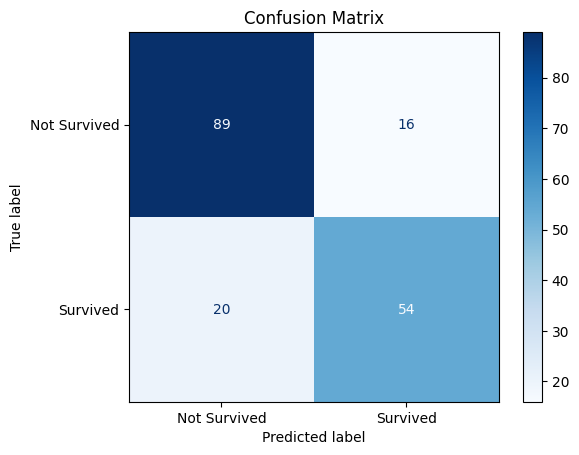

In [21]:
cm_1 = confusion_matrix(Y_val, predictions_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=["Not Survived", "Survived"])
disp.plot(cmap="Blues")  
plt.title("Confusion Matrix")
plt.show()

for model 2:

In [22]:
predictions_2 = rf.fit(X_train, Y_train).predict(X_val)
ac = accuracy_score(Y_val, predictions_2)
prc = precision_score(Y_val, predictions_2)
re = recall_score(Y_val, predictions_2)
f1 = f1_score(Y_val, predictions_2)
print( "Model Evaluation Metrics:")
print("Accuracy:",ac)
print("Precision:",prc)
print("Recall:",re)
print("F1 Score:",f1)

Model Evaluation Metrics:
Accuracy: 0.8212290502793296
Precision: 0.8
Recall: 0.7567567567567568
F1 Score: 0.7777777777777778


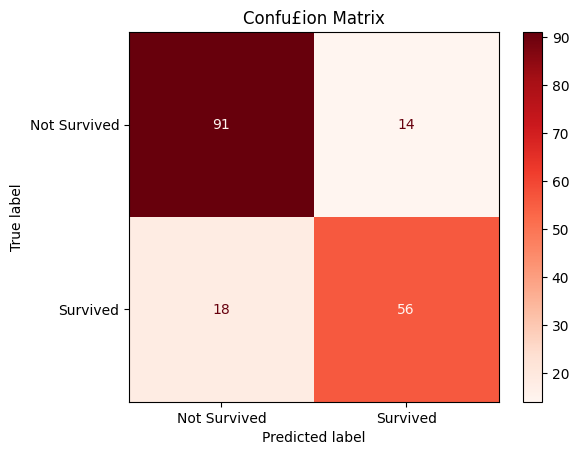

In [23]:
cm_2 = confusion_matrix(Y_val, predictions_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Not Survived", "Survived"])
disp.plot(cmap="Reds")  
plt.title("Confu£ion Matrix")
plt.show()

In [24]:
test = test[X_train.columns]  # Ensure same column order
predictions_1test = lm.predict(test) 
predictions_2test = rf.predict(test)     

In [25]:
df1 = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": predictions_1test,
                  })
df2 = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": predictions_2test,
                  })
df1.to_csv('model1.csv', index=False)
df2.to_csv('model2.csv', index=False)

                   